In [1]:
import pandas as pd

df = pd.read_csv('data.csv')
df.head()

,Time,Map,Kill,RWS,Rating,Won
0,07-18 02:32,Dust2,5,8.22,0.55,1
1,07-18 01:57,Dust2,16,12.40,0.98,0
2,07-16 21:34,Mirage,15,7.78,1.04,0
3,07-16 20:35,Dust2,23,9.51,1.40,0
4,07-16 20:02,Mirage,9,4.97,0.90,0


In [2]:
# is Night?
df['_time'] = pd.to_datetime(df['Time'], format='%m-%d %H:%M')

df['isNight'] = df['_time'].dt.hour.between(0, 5).astype(int)
# df['isNight'] = df['isNight'].replace({0: 2, 1: 1})
df = df.drop(columns=['_time'])

df

,Time,Map,Kill,RWS,Rating,Won,isNight
0,07-18 02:32,Dust2,5,8.22,0.55,1,1
1,07-18 01:57,Dust2,16,12.40,0.98,0,1
2,07-16 21:34,Mirage,15,7.78,1.04,0,0
3,07-16 20:35,Dust2,23,9.51,1.40,0,0
4,07-16 20:02,Mirage,9,4.97,0.90,0,0
...,...,...,...,...,...,...,...
297,05-25 01:15,Dust2,4,1.36,0.37,0,1
298,05-25 00:43,Dust2,5,3.91,0.56,0,1
299,05-24 19:46,Dust2,6,2.23,0.42,0,0
300,05-24 18:59,Dust2,5,6.10,0.56,1,0


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay


X = df[['Kill', 'RWS', 'Rating', 'Map', 'isNight']]
y = df['Won']

# One Hot
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Map']),
        ('num', 'passthrough', ['Kill', 'RWS', 'Rating', 'isNight'])
    ])

# train/test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
from sklearn.linear_model import LogisticRegression

clf = Pipeline(steps=[
    ('prep', preprocess),
    ('model', LogisticRegression(max_iter=1000))
])

clf.fit(X_train, y_train)

/Users/weilai/Documents/学习/Can-I-Win-This-CS-Game-/env/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/weilai/Documents/学习/Can-I-Win-This-CS-Game-/env/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/weilai/Documents/学习/Can-I-Win-This-CS-Game-/env/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/weilai/Documents/学习/Can-I-Win-This-CS-Game-/env/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/weilai/Documents/学习/Can-I-Win-This-CS-Game-/env/lib/python3.9/site-packages/sklearn/line

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Map']),
                                                 ('num', 'passthrough',
                                                  ['Kill', 'RWS', 'Rating',
                                                   'isNight'])])),
                ('model', LogisticRegression(max_iter=1000))])

In [5]:
y_pred = clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Loss', 'Win']))

Accuracy: 0.7704918032786885
              precision    recall  f1-score   support

        Loss       0.76      0.89      0.82        36
         Win       0.79      0.60      0.68        25

    accuracy                           0.77        61
   macro avg       0.78      0.74      0.75        61
weighted avg       0.77      0.77      0.76        61



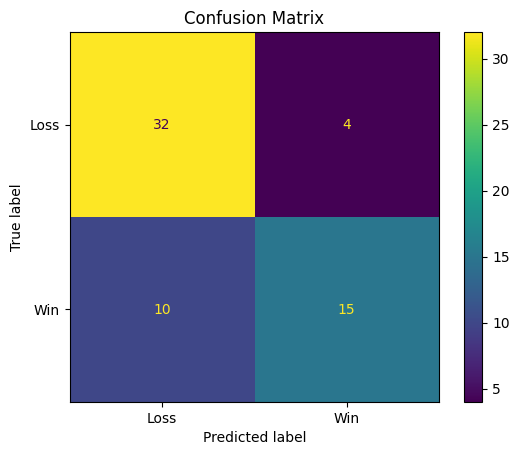

In [6]:
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['Loss', 'Win'])
plt.title('Confusion Matrix')
plt.show()

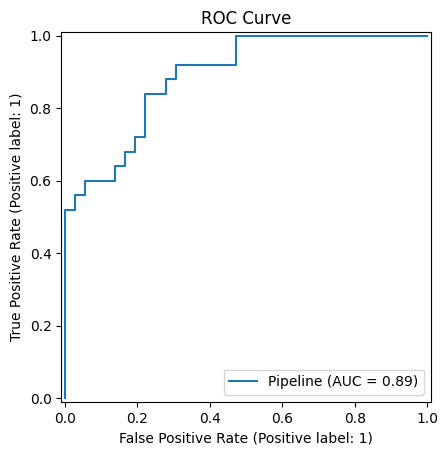

In [7]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title('ROC Curve')
plt.show()

/var/folders/72/rblc46mn5fb0t30gtdjx75n80000gn/T/ipykernel_8668/2898235411.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imp.values, y=imp.index, palette='viridis')


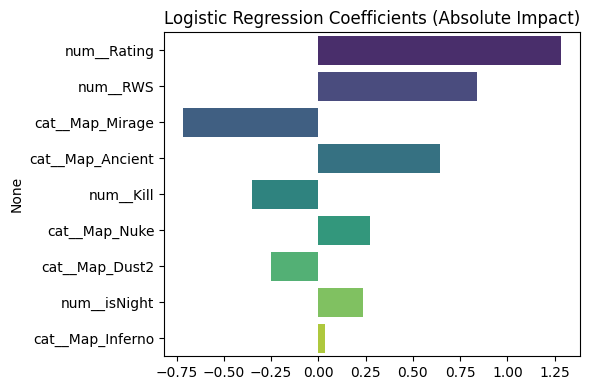

In [8]:
import numpy as np
import seaborn as sns

feature_names = clf.named_steps['prep'].get_feature_names_out()
coef = clf.named_steps['model'].coef_[0]

imp = pd.Series(coef, index=feature_names).sort_values(key=np.abs, ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x=imp.values, y=imp.index, palette='viridis')
plt.title('Logistic Regression Coefficients (Absolute Impact)')
plt.tight_layout()
plt.show()

In [ ]:
# Predict the Next Game at Mirage, Kill=12, RWS=9.0, Rating=1.0, isNight=Flase
new_match = pd.DataFrame([{'Kill': 12, 'RWS': 9.0, 'Rating': 1.0, 'Map': 'Mirage', 'isNight': False}])
prob = clf.predict_proba(new_match)[0, 1]
print(f'Predicted Winning Rate: {prob*100:.1f}%')

Predicted Winning Rate: 62.0%
